**Libraries**

---



In [0]:
from google.colab import drive
import numpy as np
import csv
import collections
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import itertools
from string import punctuation

**Mounting the Drive**

---



In [0]:
drive.mount('/content/drive', force_remount= True)


#Uncomment if you want to use Dataset prepared by us
# Make sure you've executed Cleaning.ipynb first

# TRAIN_DATA = '/content/drive/My Drive/OurDataset/train.csv'
# TEST_DATA = '/content/drive/My Drive/OurDataset/test.csv'

#Uncomment if you want to use Dataset prepared by the authors of the paper Character-level Convolutional Networks for Text
#Classification

TRAIN_DATA = '/content/drive/My Drive/AG_News/train.csv'
TEST_DATA = '/content/drive/My Drive/AG_News/test.csv'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DIR = '/content/drive/My Drive/GoogleNews-vectors-negative300-SLIM.bin'

**Data Pre-Processing**

---



In [0]:
def get_all_words(path):  
#make list of labels, and list of (title+description)
    texts, labels = [], []
    with open(path) as csv_file:
        reader = csv.reader(csv_file, quotechar='"')
        for idx, line in enumerate(reader):
            text = ""
            text = line[1]+' '+line[2]
            label = int(line[0])-1 
            texts.append(text)
            labels.append(label)
    # print(texts[0])
    cleaned_text=[]
    #keep only alphabets,numbers and space
    keeplist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789')
    for ln in texts:
        cleaned = ''.join(filter(keeplist.__contains__, ln))
        cleaned = cleaned.lower()
        cleaned_text.append(cleaned)
    

    # print(cleaned_text[:10])

    all_words,words=[],[]
    for ln in cleaned_text:
        words = ln.split()
        all_words.append(words)
    
    return all_words,labels


**Creating Datasets**

---



In [0]:
all_words_train, labels_list_train = get_all_words(TRAIN_DATA)
all_words_test,labels_list_test = get_all_words(TEST_DATA)

**Initialising the Pre-Trained Embedding Model**

---



In [0]:
#adopt the embedding model
from gensim.models import KeyedVectors

embed_lookup = KeyedVectors.load_word2vec_format(DIR, binary=True)             

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#store the pretrained words from the model in an array
embedded_words = []
for word in embed_lookup.vocab:
    embedded_words.append(word)
embedded_words = [word.lower() for word in embedded_words]

In [0]:
#for each word, get word embeddings
#embedding details- length: 300, size of vocab: 3000000
# i = 1
# word = embedded_words[i] 
# embedding = embed_lookup[word]

#lowercase
# embedded_words = [word.lower() for word in embedded_words]

**Encode words using the embedding**

---



In [0]:
def tokenize(embed_lookup, all_words):
        
    tokenized = []
    for element in all_words:
        temp = []
        for word in element:
            try:
                tok = embed_lookup.vocab[word].index
            except: 
                tok = 0
            temp.append(tok)
        tokenized.append(temp)
    
    return tokenized

In [0]:
tokenized_train = tokenize(embed_lookup,all_words_train)
tokenized_test = tokenize(embed_lookup,all_words_test)

**Finding the optimal Length of Vectors**

---



In [0]:
count = [0,0,0,0,0,0]
for line in tokenized_train:
    length = len(line)
    if length<50:
        count[0]+=1
    elif length<100:
        count[1]+=1
    elif length<150:
        count[2]+=1
    elif length<200:
        count[3]+=1
    elif length<250:
        count[4]+=1
    else:
        count[5]+=1

print(count)
print("Most of the lines thus have less than 150 words, suitable seq_len for truncation")


[111387, 8424, 183, 6, 0, 0]
Most of the lines thus have less than 150 words, suitable seq_len for truncation


**Padding and Truncating Vectors**

---



In [0]:
#convert vectors to same size by padding short ones, and truncating larger ones
def pad_and_truncate(tokenized,length):
    feature_vectors = np.zeros((len(tokenized), length), dtype=int)

 
    for index, row in enumerate(tokenized):
        feature_vectors[index, -len(row):] = np.array(row)[:length]
    
    return feature_vectors

In [0]:
train_feature_vectors = pad_and_truncate(tokenized_train,150)
test_feature_vectors = pad_and_truncate(tokenized_test,150)

In [0]:
#converting arrays containing information about class labels to numpy arrays
labels_train = np.array(labels_list_train)
labels_test = np.array(labels_list_test)


**Training, Validation and Test Sets**

---



In [0]:
spl_idx = 100000

train_set, val_set = train_feature_vectors[:spl_idx], train_feature_vectors[spl_idx:]
train_labels, val_labels = labels_train[:spl_idx], labels_train[spl_idx:]
test_set = test_feature_vectors
test_labels = labels_test

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_set.shape), 
      "\nValidation set: \t{}".format(val_set.shape),
      "\nTest set: \t\t{}".format(test_set.shape))

			Feature Shapes:
Train set: 		(100000, 150) 
Validation set: 	(20000, 150) 
Test set: 		(7600, 150)


**Loading the Dataset**: To be fed into the Network

---



In [0]:
train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_labels))
validation_data = TensorDataset(torch.from_numpy(val_set), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_labels))

batch_size = 128 # to match charCNN 

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [0]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


**Defining The Network**

---



In [0]:
class WordCNN(nn.Module):
    def __init__(self, embed_model, input_dim, n_conv_filters, n_fc_neurons, embedding_dim = 300, n_classes=4, input_length=150):

        super(WordCNN, self).__init__()

        # 1. embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors))

        self.conv1 = nn.Conv1d(embedding_dim, n_conv_filters, kernel_size=7, padding=0)
        self.conv2 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=7, padding=0)
        self.conv3 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv4 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv5 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)
        self.conv6 = nn.Conv1d(n_conv_filters, n_conv_filters, kernel_size=3, padding=0)

        dimension = int(((input_length - 96) / 27) * n_conv_filters) # since the stride used for max_pool is 3 and not 1!!!
        #dimension = 8704
        self.fc1 = nn.Linear(dimension, n_fc_neurons)   
        self.fc2 = nn.Linear(n_fc_neurons, n_fc_neurons)
        self.out = nn.Linear(n_fc_neurons, n_classes)

        if n_conv_filters == 256 and n_fc_neurons == 1024:
            self._create_weights(mean=0.0, std=0.05)
        elif n_conv_filters == 1024 and n_fc_neurons == 2048:
            self._create_weights(mean=0.0, std=0.02)

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std)
                
       
    
    def forward(self, t):
        #define input layer
        t = self.embedding(t) 
        t = t.transpose(1, 2) 
        
        #define hidden layers

        #convolution layers #1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
        
        #2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
       
        #3
        t = self.conv3(t)
        t = F.relu(t)
        
        #4
        t = self.conv4(t)
        t = F.relu(t)

        #5
        t = self.conv5(t)
        t = F.relu(t)
        
        #6
        t = self.conv6(t)
        t = F.relu(t)
        t = F.max_pool1d(t,3)
        #F.max_pool1d

       
        
        #Fully_Connected Layers
        t = t.view(t.size(0), -1)
        # t = t.reshape(-1, 65536) #to define the size for fully connected layers

        t = self.fc1(t)
        t = F.dropout(t,0.5)

        t = self.fc2(t)
        t = F.dropout(t,0.5)
       
        t = self.out(t)
        
        #t = F.softmax(t,dim = 1) #check the dimension according to the size!!!
        #not applied softmax because in the input of crossentropy loss function, it automatically takes the softmax of every input!!!
        return t

**Initialising the Network**

---


(Choose between training on Small Features v/s Large Features)

In [0]:
vocab_size = len(embedded_words)
output_size = 4
embedding_dim = len(embed_lookup[embedded_words[0]]) # 300-dim vectors

n_conv_filters_small = 256
n_conv_filters_large = 1024
n_fc_neurons_small = 1024
n_fc_neurons_large = 2048

# Uncomment for training on small feature
# model = WordCNN(embed_lookup, vocab_size, n_conv_filters_small, n_fc_neurons_small, embedding_dim,)

# Uncomment for training on large feature
model = WordCNN(embed_lookup, vocab_size, n_conv_filters_large, n_fc_neurons_large, embedding_dim)

print(model)

WordCNN(
  (embedding): Embedding(3000000, 300)
  (conv1): Conv1d(300, 1024, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(1024, 1024, kernel_size=(7,), stride=(1,))
  (conv3): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (out): Linear(in_features=2048, out_features=4, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 

**Function to Compute Accuracy**

---



In [0]:
def get_accuracy(y_true, y_pred):
    y_pred = np.argmax(y_pred, -1)
    output = {}
    output['accuracy'] = metrics.accuracy_score(y_true, y_pred)
    return output

**Training**

---



In [0]:
def train(net, train_loader, valid_loader, epochs, val_set_len, criterion, optimizer):

    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)

    # move model to GPU, if available
    if(train_on_gpu):
        net.cuda()
    
    # train for some number of epochs
    net.train()

    train_loss_plot = []
    loss_plot = []
    epoch_plot = []     
    for e in range(epochs):
        # batch loop
        for features, labels in train_loader:

            if(train_on_gpu):
                features, labels = features.cuda(), labels.cuda()

            net.zero_grad()

            # get the output from the model
            output = net(features)

            # calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_accuracy = get_accuracy(labels.cpu().numpy(), output.cpu().detach().numpy())
            
        net.eval()
        loss_ls = []
        val_label_ls = []
        val_pred_ls = []

        for batch in valid_loader:
            val_feature, val_label = batch
            num_sample = len(val_label)
            if torch.cuda.is_available():
                val_feature = val_feature.cuda()
                val_label = val_label.cuda()
            with torch.no_grad():
                val_predictions = net(val_feature)
            val_loss = criterion(val_predictions, val_label)
    
            loss_ls.append(val_loss * num_sample)
            
            val_label_ls.extend(val_label.clone().cpu())
            val_pred_ls.append(val_predictions.clone().cpu())

        val_loss = sum(loss_ls) / val_set_len

        loss_plot.append(val_loss)
        epoch_plot.append(e)
        train_loss_plot.append(loss)

        val_pred = torch.cat(val_pred_ls, 0)
        val_label = np.array(val_label_ls)

        val_accuracy = get_accuracy(val_label, val_pred.numpy())
            
        print("Epoch: {}/{}..... Lr: {}.... Validation Loss: {}..... Validation Accuracy: {}".format(
                e + 1,
                epochs,
                optimizer.param_groups[0]['lr'],
                val_loss, val_accuracy))
        
        if e % 3 == 0 and e > 0:
            current_lr = optimizer.state_dict()['param_groups'][0]['lr']
            current_lr /= 2
            for param_group in optimizer.param_groups:
               param_group['lr'] = current_lr


    return train_loss_plot, loss_plot, epoch_plot;


In [0]:
epochs = 15

train_loss_plot, loss_plot, epoch_plot = train(model, train_loader, validation_loader, epochs, test_data.__len__(), criterion, optimizer)

Epoch: 1/15..... Lr: 0.01.... Validation Loss: 1.969560146331787..... Validation Accuracy: {'accuracy': 0.68785}
Epoch: 2/15..... Lr: 0.01.... Validation Loss: 1.4672366380691528..... Validation Accuracy: {'accuracy': 0.789}
Epoch: 3/15..... Lr: 0.01.... Validation Loss: 0.8914090394973755..... Validation Accuracy: {'accuracy': 0.87765}
Epoch: 4/15..... Lr: 0.01.... Validation Loss: 0.9078297019004822..... Validation Accuracy: {'accuracy': 0.87675}
Epoch: 5/15..... Lr: 0.005.... Validation Loss: 0.9174632430076599..... Validation Accuracy: {'accuracy': 0.8747}
Epoch: 6/15..... Lr: 0.005.... Validation Loss: 0.8203669190406799..... Validation Accuracy: {'accuracy': 0.88885}
Epoch: 7/15..... Lr: 0.005.... Validation Loss: 0.8637486100196838..... Validation Accuracy: {'accuracy': 0.8822}
Epoch: 8/15..... Lr: 0.0025.... Validation Loss: 0.7933095097541809..... Validation Accuracy: {'accuracy': 0.89225}
Epoch: 9/15..... Lr: 0.0025.... Validation Loss: 0.8388317227363586..... Validation Accu

**Validation Loss Graph**

---



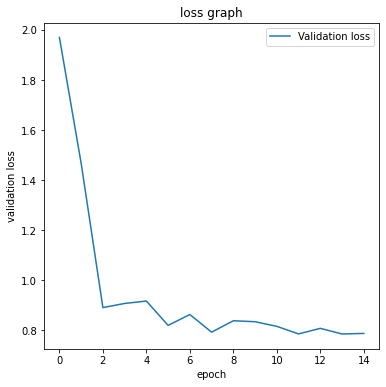

In [0]:
test = plt.figure(figsize=(6,6))
plt.plot(epoch_plot, loss_plot,label='Validation loss')
# plt.plot(epoch_plot, train_loss_plot, label='Training loss')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('loss graph')
plt.legend()
test.show()

In [0]:
cm_savepath = '/content/drive/My Drive/NNFL_PROJ/SCREENSHOTS/WordCNN/'
test.savefig(cm_savepath+ 'loss_15epochs_large_author.png')

**Test Function**

---



In [0]:
model.eval()

loss_ls = []
te_label_ls = []
te_pred_ls = []
for batch in test_loader:
    te_feature, te_label = batch
    num_sample = len(te_label)
    if torch.cuda.is_available():
        te_feature = te_feature.cuda()
        te_label = te_label.cuda()
    with torch.no_grad():
        te_predictions = model(te_feature)
        #print(te_predictions.argmax(dim=1))
    te_loss = criterion(te_predictions, te_label)
    loss_ls.append(te_loss * num_sample)
    te_label_ls.extend(te_label.clone().cpu())
    te_pred_ls.append(te_predictions.clone().cpu())

te_loss = sum(loss_ls) / test_set.__len__()
te_pred = torch.cat(te_pred_ls, 0)
te_label = np.array(te_label_ls)

test_accuracy = get_accuracy(te_label,te_pred.numpy())  
      
print("Epoch: {}/{}.... Lr: {}.... Loss: {}..... Accuracy: {}".format(
            2,
            2,
            optimizer.param_groups[0]['lr'],
            te_loss, test_accuracy)
)

cm = confusion_matrix(te_label, te_pred.argmax(dim=1))
print("raw form of confusion matrix")
print(cm)

print("Classification Report")
target_names = ['World','Sports','Business','Sci/Tech']
print(classification_report(te_label, te_pred.argmax(dim=1), target_names=target_names))

Epoch: 2/2.... Lr: 0.000625.... Loss: 0.3092607259750366..... Accuracy: {'accuracy': 0.8936842105263157}
raw form of confusion matrix
[[1692   61   79   68]
 [  27 1842   13   18]
 [  67   25 1593  215]
 [  54   21  160 1665]]
Classification Report
              precision    recall  f1-score   support

       World       0.92      0.89      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.86      0.84      0.85      1900
    Sci/Tech       0.85      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



**Prediction Results**

---



In [0]:
te_pred_softmax = F.softmax(te_pred, dim=1)
pred = te_pred_softmax.argmax(dim=1)
print("Results predicted from model....")
print(pred[0:20])
print("Actual labels....")
print(te_label[0:20])

Results predicted from model....
tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Actual labels....
[2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


**Confusion Matrix**

---



In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1692   61   79   68]
 [  27 1842   13   18]
 [  67   25 1593  215]
 [  54   21  160 1665]]


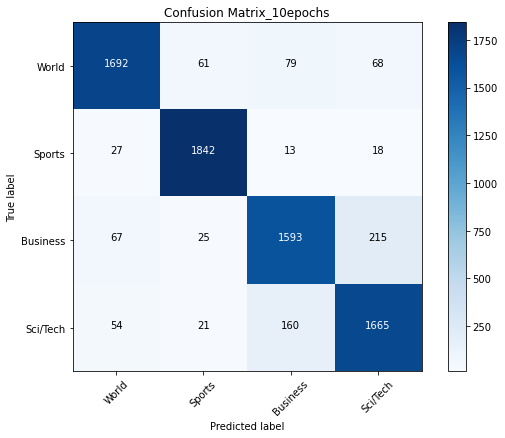

In [0]:
cm = confusion_matrix(labels_test, te_pred.argmax(dim=1))
#print(type(cm))
#cm
names = (
    'World',
'Sports',
'Business',
'Sci/Tech'
)
plt.figure(figsize=(8,6))

Title = 'Confusion Matrix_10epochs'
plot_confusion_matrix(cm, names,title = Title)

cm_savepath = '/content/drive/My Drive/NNFL_PROJ/SCREENSHOTS/WordCNN/'
plt.savefig(cm_savepath+ 'cm_15epochs_large_author.png')

**Predict Class of Random News Sample**

---



In [0]:
def predict(embed_lookup, net , test_news, sequence_length=150):

    net.eval()
    
    # tokenize review
    test_ints = tokenize_news(embed_lookup, test_news)
    
    # pad/truncate tokenized sequence
    seq_length=sequence_length
    features = pad_and_truncate([test_ints], seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output = net(feature_tensor) #use feature_tensor.unsqueeze(0) if not working
    
    # convert output to find the maximum index as done by softmax
    te_pred_softmax = F.softmax(output, dim=1)
    pred = te_pred_softmax.argmax(dim=1)
    
    if(pred.item()==0):
        print("World news detected!")
    elif(pred.item()==1):
        print("Sports news detected!")
    elif(pred.item()==2):
        print("Business news detected!")
    elif (pred.item()==3):
        print("Sci/Tech news detected!")

In [0]:
# helper function to process and tokenize a single review
def tokenize_news(embed_lookup, test_news):
    
    test_text = ''.join([c for c in test_news if c not in punctuation])
    test_words = test_text.split()

    tokenized_review = []
    for word in test_words:
        try:
            idx = embed_lookup.vocab[word].index
        except: 
            idx = 0
        tokenized_review.append(idx)

    return tokenized_review

In [0]:
seq_length = 150

In [0]:
line =  'LOS ANGELES (Reuters) - A group of technology companies  including Texas Instruments Inc. &lt;TXN.N&gt;, STMicroelectronics  &lt;STM.PA&gt; and Broadcom Corp. &lt;BRCM.O&gt;, on Thursday said they  will propose a new wireless networking standard up to 10 times  the speed of the current generation.'
line = line.lower()
predict(embed_lookup, model, line, seq_length)

Sci/Tech news detected!


In [0]:
line = 'The Cleveland Indians pulled within one game of the AL Central lead by beating the Minnesota Twins, 7-1, Saturday night with home runs by Travis Hafner and Victor Martinez.'
line = line.lower()
predict(embed_lookup, model, line, seq_length)

Sports news detected!


In [0]:
line = 'BEIJING (Reuters) - Beijing on Monday accused a  Chinese-American arrested for spying for Taiwan of building an  espionage network in the United States, and said he could go on  trial very soon.'
line = line.lower()
predict(embed_lookup, model, line, seq_length)

World news detected!


In [0]:
line = 'HONG KONG (Dow Jones)--China Mobile (Hong Kong) Ltd. (CHL), the listed unit of China #39;s biggest cellular phone operator, posted Wednesday a 7.8 rise in first-half net profit on a 23 increase in its subscriber base. '
line = line.lower()
predict(embed_lookup, model, line, seq_length)

Business news detected!
